In [ ]:
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [ ]:
!pip install wandb
import wandb
from wandb.keras import WandbCallback

In [ ]:
# Installing pre-requisite for saving the model
!pip install pyyaml h5py

In [ ]:
# Mount google drive where dataset is stored at
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Import necessary libraries
from tensorflow.keras.applications.resnet_v2 import ResNet50V2
from tensorflow.keras.applications.resnet_v2 import preprocess_input, decode_predictions
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, GlobalAveragePooling2D, BatchNormalization, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
import os
import numpy as np
import pandas as pd

In [ ]:
# Configuration settings 
configs = {
    'epochs': 20,
    'batch_size': [1, 4, 8, 16, 32, 64], 
    'seed': 7,
    'learning_rate': 1e-3, #0.001
    'hidden_activation': 'relu',
    'output_activation': 'sigmoid',
    'optimizer': 'adam',
    'loss_function': 'binary_crossentropy',
    'metrics': ['accuracy'],
    'fc_layer_1_neurons' : 1024,
    'fc_layer_2_neurons' : 512,
    'fc_layer_3_neurons' : 256,
}

# Initialise Wandb
batch_size_tuning = wandb.init(
    name='resnet50V2_batch_size',
    project='CZ4042_Assignment_2_Hyperparameter_Tuning',
    config= configs,
)

config = wandb.config
tf.random.set_seed(config.seed)

wandb: Currently logged in as: dloe001 (use `wandb login --relogin` to force relogin)


In [ ]:
# Define the google drive path where data is stored
base_path = '/content/drive/MyDrive/CZ4042 Project Assignment 2/Models/'

# Load preprocessed dataset containing image path and gender as dataframe
df = pd.read_csv(base_path + 'processed_path_and_gender.txt', sep='\t')

# Split the dataset 80% train / 20% test
train_df, test_df = train_test_split(df, test_size=0.2, random_state = config.seed)

# Append the google drive path infront of the image path 
train_df['data_path'] = base_path + train_df['data_path'].astype(str)
test_df['data_path'] = base_path + test_df['data_path'].astype(str)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


In [ ]:
# Creating the resnet50V2 model
def get_resnet50V2_model():

  seq = tf.keras.models.Sequential()

  seq.add(ResNet50V2(include_top=False, pooling = 'avg', weights ='imagenet', input_shape=(224,224,3)))

  seq.add(Flatten())

  seq.add(BatchNormalization())

  seq.add(Dense(config.fc_layer_1_neurons, activation = config.hidden_activation))

  seq.add(BatchNormalization())

  seq.add(Dense(config.fc_layer_2_neurons, activation = config.hidden_activation))

  seq.add(BatchNormalization())

  seq.add(Dense(config.fc_layer_3_neurons, activation = config.hidden_activation))

  seq.add(BatchNormalization())

  seq.add(Dense(1, activation= config.output_activation))
  
  seq.layers[0].trainable = False

  return seq

In [ ]:
model = get_resnet50V2_model()

# View summary of model
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50v2 (Functional)      (None, 2048)              23564800  
_________________________________________________________________
flatten (Flatten)            (None, 2048)              0         
_________________________________________________________________
batch_normalization (BatchNo (None, 2048)              8192      
_________________________________________________________________
dense (Dense)                (None, 1024)              2098176   
_________________________________________________________________
batch_normalization_1 (Batch (None, 1024)              4096      
_________________________________________________________________
dense_1 (Dense)              (None, 512)               524800    
_________________________________________________________________
batch_normalization_2 (Batch (None, 512)               2

In [ ]:
# Set of batch sizes to test
no_batch_size = [1, 4, 8, 16, 32, 64]
historyArr = []
meanAccArr = []

# Initialise ImageDataGenerator 
# Perform rescaling using resnet50V2's preprocess_input method
train_image_generated = ImageDataGenerator(preprocessing_function = preprocess_input)
test_image_generated = ImageDataGenerator(preprocessing_function = preprocess_input)

def train_model(no_batch_size):
  model = get_resnet50V2_model()
  
  # Generate the rescaled train images from the dataframe given 
  train_ds = train_image_generated.flow_from_dataframe(
      dataframe = train_df,
      x_col ='data_path',
      y_col = 'gender',
      batch_size = config.batch_size,
      seed = config.seed,
      shuffle = True,
      class_mode ='raw',
      target_size = (224,224),
  )

  # Generate the rescaled test images from the dataframe given 
  test_ds = test_image_generated.flow_from_dataframe(
      dataframe = test_df,
      x_col = 'data_path',
      y_col = 'gender',
      batch_size = config.batch_size,
      seed = config.seed,
      shuffle = True,
      class_mode = 'raw',
      target_size = (224,224),
  )

  # Compile the model
  train_history = model.compile(
    optimizer = config.optimizer,
    loss = config.loss_function,
    metrics = config.metrics,
  )

  # Checkpoint storing path
  checkpoint_path = base_path + "Model Checkpoints/" + "resnet50V2_cp.ckpt"
  checkpoint_dir = os.path.dirname(checkpoint_path)

  # Model checkpoint to store best weights
  model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
      filepath= checkpoint_path,
      save_weights_only=True,
      monitor='val_accuracy',
      mode='max',
      save_best_only=True)

  # Training the model
  train_history = model.fit(
      train_ds,
      epochs= config.epochs,
      use_multiprocessing=True,
      callbacks=[WandbCallback()],
      validation_data=test_ds,
  )

  meanAcc = np.mean(train_history.history['val_accuracy'], axis = 0)
  print("\n")
  
  return meanAcc, train_history

In [ ]:
for size in no_batch_size:
  print("Batch size: ", size)
  meanAcc_, history_ = train_model(size)
  meanAccArr.append(meanAcc_)
  historyArr.append(history_)

Batch size:  1
Found 9755 validated image filenames.
Found 2439 validated image filenames.
Epoch 1/20
9755/9755 [==============================] - 170s 17ms/step - loss: 0.6930 - accuracy: 0.5221 - val_loss: 94229.2422 - val_accuracy: 0.4715


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 2/20
9755/9755 [==============================] - 164s 17ms/step - loss: 0.6926 - accuracy: 0.5211 - val_loss: 20492.5566 - val_accuracy: 0.5547
Epoch 3/20
9755/9755 [==============================] - 164s 17ms/step - loss: 0.6928 - accuracy: 0.5230 - val_loss: 48285.0352 - val_accuracy: 0.4711
Epoch 4/20
9755/9755 [==============================] - 164s 17ms/step - loss: 0.6929 - accuracy: 0.5235 - val_loss: 67307.3359 - val_accuracy: 0.4584
Epoch 5/20
9755/9755 [==============================] - 169s 17ms/step - loss: 0.6926 - accuracy: 0.5212 - val_loss: 98416.7188 - val_accuracy: 0.4719
Epoch 6/20
9755/9755 [==============================] - 171s 17ms/step - loss: 0.6928 - accuracy: 0.5228 - val_loss: 42004.9648 - val_accuracy: 0.4764
Epoch 7/20
9755/9755 [==============================] - 172s 18ms/step - loss: 0.6924 - accuracy: 0.5271 - val_loss: 28072.5078 - val_accuracy: 0.5699
Epoch 8/20
9755/9755 [==============================] - 171s 17ms/step - loss: 0.6928 - accura

In [ ]:
bestBatchSize = []
bestBatchSize.append(no_batch_size[np.argmax(meanAccArr)])

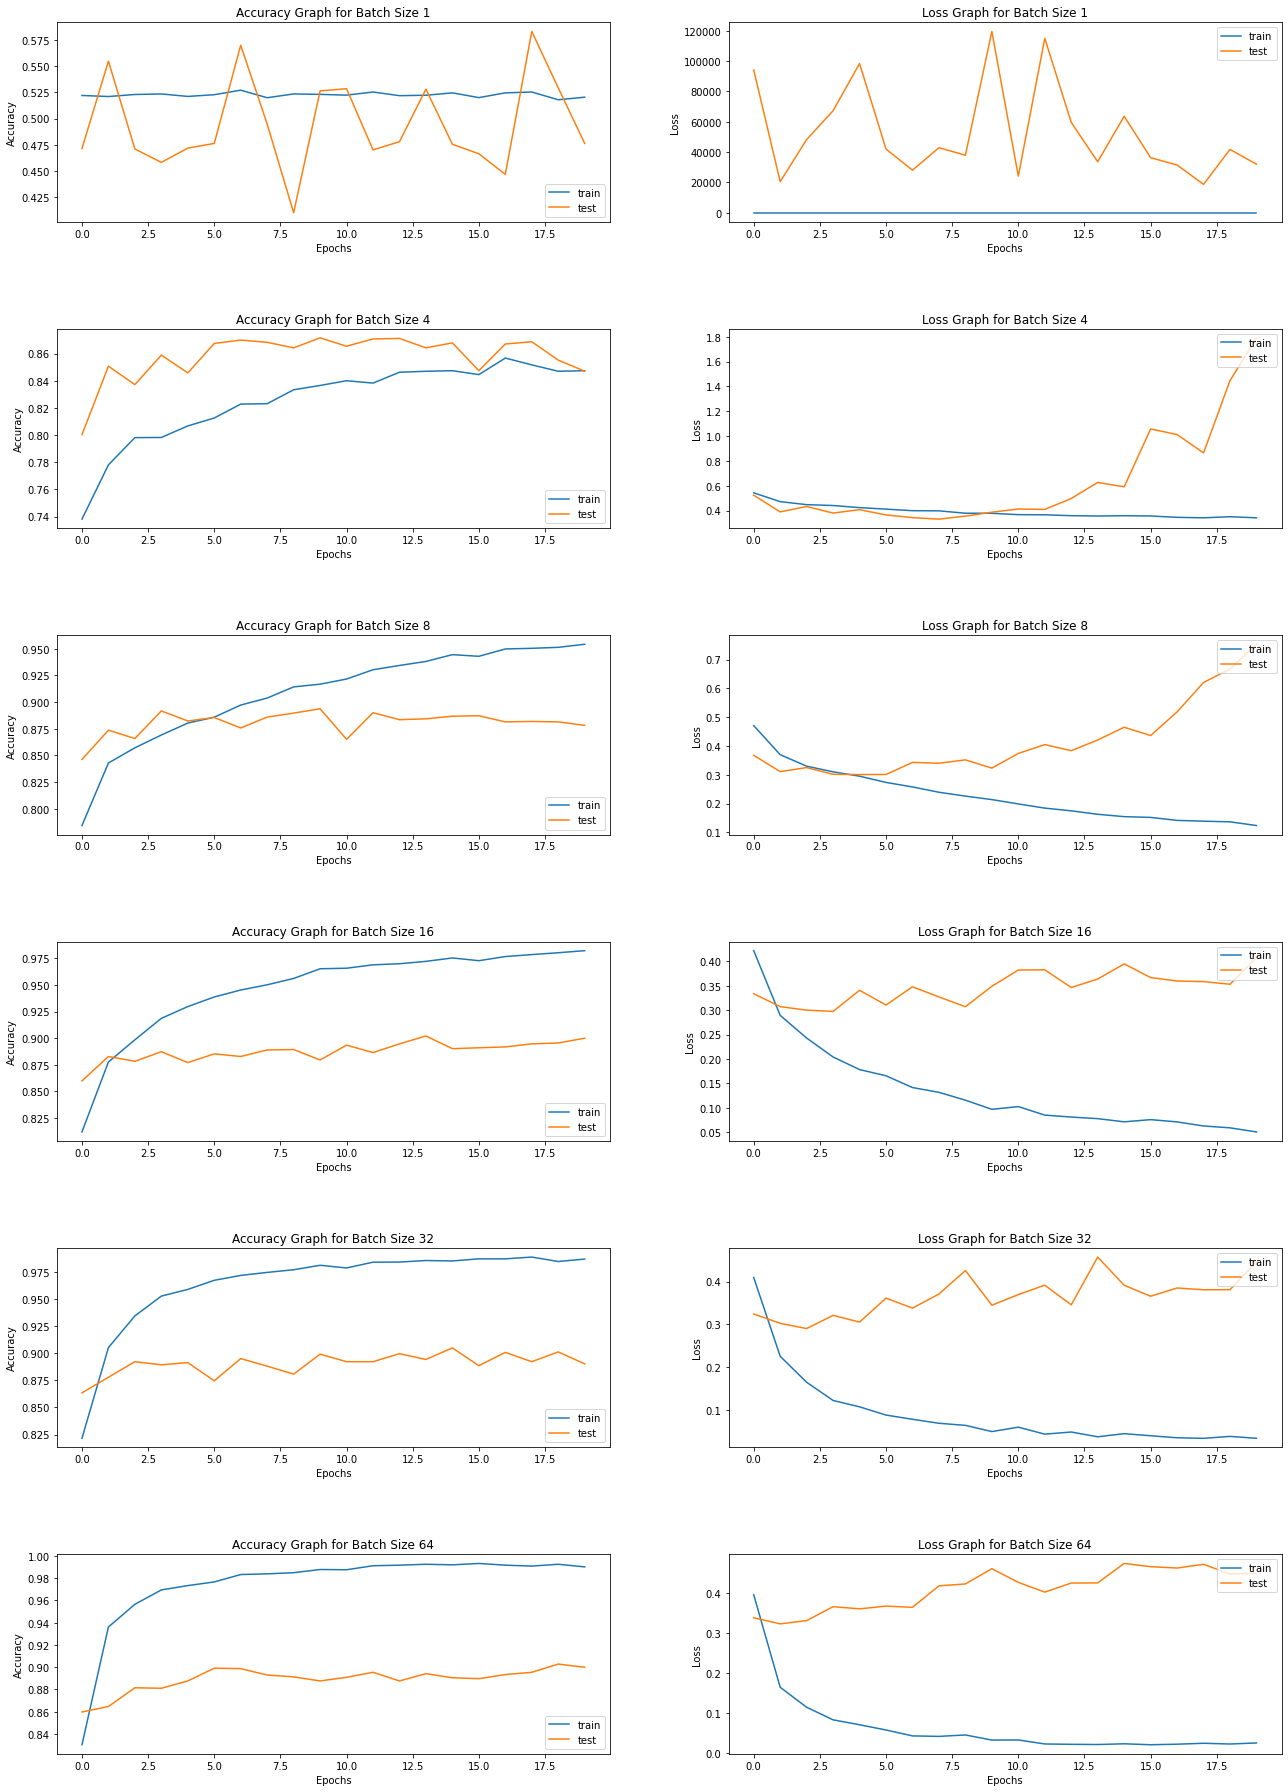

In [ ]:
# Create plot spaces for (6x2) subplot with figure size of (18x25)
f, axes = plt.subplots(6, 2, figsize=(18, 25))

# Plotting the graphs to see accuracy and loss over epochs for the different batch sizes selected (1, 4, 8, 16, 32, 64)
for i in range(len(no_batch_size)):
    # Accuracy graph for the different batch sizes
    axes[i,0].plot(historyArr[i].history['accuracy'])
    axes[i,0].plot(historyArr[i].history['val_accuracy'])
    axes[i,0].set_title('Accuracy Graph for Batch Size ' + str(no_batch_size[i]))
    axes[i,0].set(xlabel='Epochs', ylabel='Accuracy')
    axes[i,0].legend(['train', 'test'], loc='lower right')

    # Loss graph for the different batch sizes
    axes[i,1].plot(historyArr[i].history['loss'])
    axes[i,1].plot(historyArr[i].history['val_loss'])
    axes[i,1].set_title('Loss Graph for Batch Size ' + str(no_batch_size[i]))
    axes[i,1].set(xlabel='Epochs', ylabel='Loss')
    axes[i,1].legend(['train', 'test'], loc='upper right')

# Spacing between each graph
f.tight_layout(h_pad=6, w_pad=6)

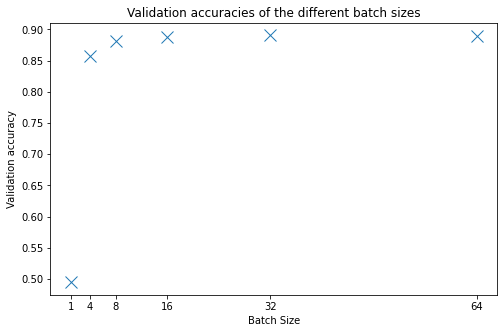

In [ ]:
# Scatter plot of the validation accuracy for the different batch sizes
plt.figure(figsize=(8, 5))
plt.title("Validation accuracies of the different batch sizes")
plt.plot(no_batch_size, meanAccArr, marker = 'x', linestyle = 'None',  markersize=12)
plt.xticks([1, 4, 8, 16, 32, 64])
plt.xlabel('Batch Size')
plt.ylabel('Validation accuracy')
plt.show()

In [ ]:
# Printing the best batch size to be used for the final model
print(bestBatchSize)

[32]
